# Exploring gradient receptive fields in combination with PCA

This notebook is playing around with plotting radient receptive fields in combination with a different number of PCs included. 

For a more detailed description, please refer to the analysis_of_RF_V4.ipynb notebook. Here, one can find some other interesting examples, but it is more unstructured and explorative than analysis_of_RF_V4.ipynb. 

In [159]:
%load_ext autoreload
%autoreload 

import numpy as np
from numpy.linalg import eig
from numpy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.colors as mat_col
import torch

import nnfabrik
from nnfabrik import builder


import numpy as np
import pickle
import os

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import nnvision

from nnfabrik.main import *

In [6]:
import datajoint as dj
dj.config['enable_python_native_blobs'] = True


dj.config['database.user']= 'kanderer'
dj.config['database.password']= 'enamel-vendetta-deodorant'


schema_name = 'nnfabrik_monkey_saliency'

schema = dj.schema(schema_name, locals())
dj.config['nnfabrik.schema_name'] = schema_name


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import datajoint as dj

dj.config['enable_python_native_blobs'] = True

from nnfabrik.templates.trained_model import TrainedModelBase
from nnfabrik.main import *
import os

if not 'stores' in dj.config:
    dj.config['stores'] = {}
    
dj.config['stores']['minio'] = {  # store in s3
    'protocol': 's3',
    'endpoint': os.environ.get('MINIO_ENDPOINT', 'DUMMY_ENDPOINT'),
    'bucket': 'nnfabrik',
    'location': 'dj-store',
    'access_key': os.environ.get('MINIO_ACCESS_KEY', 'FAKEKEY'),
    'secret_key': os.environ.get('MINIO_SECRET_KEY', 'FAKEKEY')
}

In [12]:
basepath = '/data/monkey/toliaslab/CSRF19_V4'
neuronal_data_path = os.path.join(basepath, 'neuronal_data/')
neuronal_data_files = [neuronal_data_path + f for f in listdir(neuronal_data_path) if isfile(join(neuronal_data_path, f))]
image_cache_path = os.path.join(basepath, 'images')

saliency_cache_path = os.path.join(basepath, 'images_saliency')
print(saliency_cache_path)

/data/monkey/toliaslab/CSRF19_V4/images_saliency


In [13]:
@schema
class TrainedModel(TrainedModelBase):
    table_comment = "Trained models"
    storage = "minio"
    model_table = Model
    dataset_table = Dataset
    trainer_table = Trainer
    seed_table = Seed
    user_table = Fabrikant

In [14]:
key = dict(model_hash='cec63aa4435b2a205ec02eafc0a745ee', dataset_hash='ce98e82c2543a503de7611648340380e', trainer_hash = 'f03a6527ab0422767da50e67e2d543ef')

dataloader, model = (TrainedModel & key).load_model()

In [544]:
model

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(15, 15), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), groups=32, bias=False)
          (out_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          

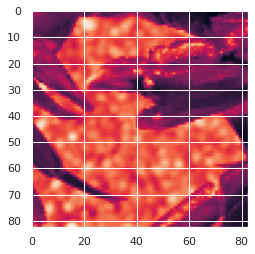

In [549]:


images = dataloader["train"]["3645713184967"].dataset[:].inputs

images2 = dataloader["train"]["3654087847388"].dataset[:].inputs

plt.imshow(images2[0,:,:].squeeze(0).squeeze(0))
responses = dataloader["train"]["3645713184967"].dataset[:].targets



### 1. Get the best neurons based on test correlation scores

In [17]:
from nnvision.tables.scores import TestCorrelationScore
from nnvision.tables.main import Recording
from nnvision.tables.scores import TestCorrelationScoreEnsemble

In [15]:
Recording.Units

Recording.populate()

In [947]:
best_five = (Recording.Units*TestCorrelationScore.Units & key).fetch("data_key", "unit_id","unit_index", "unit_test_correlation",limit=5, order_by="unit_test_correlation DESC", as_dict=True)

In [949]:
best_20 = (Recording.Units*TestCorrelationScore.Units & key).fetch("data_key", "unit_id","unit_index", "unit_test_correlation",limit=20, order_by="unit_test_correlation DESC", as_dict=True)#best_5 = (TestCorrelationScore.Units & key).fetch("KEY", "unit_test_correlation", limit=5, order_by="unit_test_correlation DESC")

### 2. Get a bunch of Gradient receptive fields

In [ ]:
# I'd start to calculate the RFs only for a bunch of neurons - for 2000 images and 200 Neurons, that cell took me about an hour to compute.

n_images = 100 # 100 images would also be fine

n_neurons = 20

RFs = torch.zeros(n_neurons, n_images,*images.shape[1:]) # preallocating RFs

img_x, img_y = images.shape[2:] # x and y dim on the image


#for i in range(n_images):

    #x = torch.rand([1,*images.shape[1::]], device='cpu', requires_grad=True)
    #x = images[i, :,:].reshape((1,1,images.shape[2], images.shape[3]))
    #plt.imshow(x.squeeze(0).squeeze(0))
    #x = torch.tensor(x.clone().detach(), device='cpu', requires_grad=True)
    
    
#iterates through the 5 neurons with the best test correlation, selects the right session with ['data_key']
j = 0
for best in best_20:
    
    images = dataloader["train"][best['data_key']].dataset[:].inputs

        
    for i in range(0, n_images):
        x = images[i, :,:].reshape((1,1,images.shape[2], images.shape[3]))
     
        x = x.clone().detach().requires_grad_(True).to('cpu')
        optimizer = torch.optim.Adam([x], lr = 1.0)
        optimizer.zero_grad()
        
        r = model(x, data_key=best['data_key'], pretrained=True)


        r[0, best['unit_index']].backward(retain_graph=True)
        RFs[j, i] = x.grad.data
    
        x.grad.data.zero_()
    j += 1

### 3. Compute the per Neuron Eigenvalues of the img_x * img_y * n_rfs Matrix with kPCA

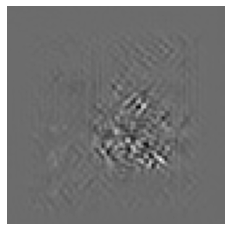

In [962]:
rfs_neuron_0 = RFs[0].cpu().detach().numpy().squeeze()

plt.imshow(rfs_neuron_0[1], cmap="gray")
plt.axis('off')

rfs_flattened = np.reshape(rfs_neuron_0,[n_images,-1])
rfs_flattened -= rfs_flattened.mean(axis=1, keepdims=True)

#Kernel matrix 
K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
uk, a = eig(K)
uc, a = map(np.real, (uk, a))

#Covariance
#C =  rfs_flattened.T @ rfs_flattened / rfs_flattened.shape[0]
#uc, v = eig(C)
#uk, v = map(np.real, (uc, v))

v2 = rfs_flattened.T @ a
v2 /= np.sqrt( (v2**2).sum(axis=0, keepdims=True)) # normalize each column to length 1 v/||v||_2
v3 = np.reshape(v2,(img_x, img_y, n_images)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component

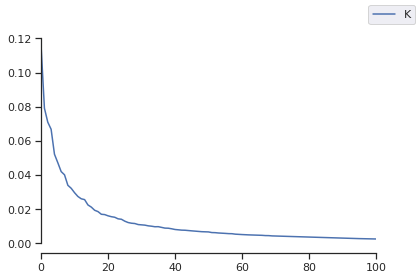

In [964]:
import seaborn as sns

with sns.axes_style('ticks'):
    fig, axs = plt.subplots()

    
axs.plot(uks[2], label = "K")

axs.set_xlim(0, 100)
sns.despine(trim=True)
fig.legend()

#### Plotting the receptive field with the first 10 components

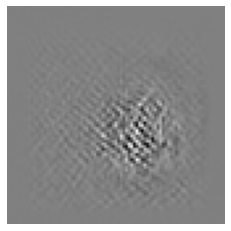

In [965]:
eigRF = np.sum(v3[:,:,0:10], axis=2)
cAxiMax = np.max(abs(eigRF))
showme = plt.imshow(eigRF.squeeze(), cmap='gray', aspect=1, vmin= -cAxiMax, vmax = cAxiMax)
plt.axis('off')
plt.show()

### 4. Compute Ratio of First and Second Component
for simple cells, we expect that the first PC will be much larger than the second PC (because of phase invariance).
This won't be quite as relevant for mouse data, but why not.

In [966]:
eig_ratio = []
uks = []
RFs_np = RFs.cpu().detach().numpy()

for i in range(0, 20):

    rfs_flattened = RFs_np[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    rfs_flattened -= rfs_flattened.mean(axis=1, keepdims=True)
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, a = eig(K)
    uk, a = map(np.real, (uk, a))
    
    uks.append(uk)
    #C = rfs_flattened.T @ rfs_flattened / rfs_flattened.shape[0]
    #uc, v = eig(C)
    #uc, v = map(np.real, (uc, v))

    eig_ratio.append(uk[1]/uk[0])


In [832]:
### finding out how much percent of the variance is explained by first 50 components
#print(uk)
#print(np.sum(uks[0][:500]))
print(np.sum(uks[0][:20])/np.sum(uks[0][:]))
print(np.sum(uks[1][:15])/np.sum(uks[1][:]))
print(np.sum(uks[2][:50])/np.sum(uks[2][:]))
print(np.sum(uks[3][:40])/np.sum(uks[3][:]))
print(np.sum(uks[4][:1])/np.sum(uks[4][:]))


0.80362415
0.85477406
0.7329209
0.81316775
0.9999702


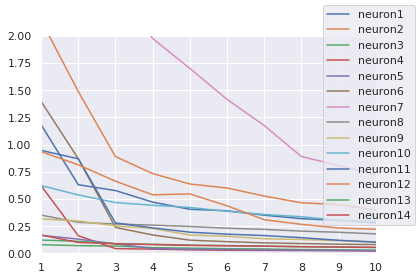

In [967]:
import seaborn as sns

with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots()


axs.plot(uks[0], label = "neuron1")
axs.plot(uks[1], label = "neuron2")
axs.plot(uks[2], label = "neuron3")
axs.plot(uks[3], label = "neuron4")
axs.plot(uks[4], label = "neuron5")
axs.plot(uks[5], label = "neuron6")
axs.plot(uks[6], label = "neuron7")
axs.plot(uks[7], label = "neuron8")
axs.plot(uks[8], label = "neuron9")
axs.plot(uks[9], label = "neuron10")
axs.plot(uks[10], label = "neuron11")
axs.plot(uks[11], label = "neuron12")
axs.plot(uks[12], label = "neuron13")
axs.plot(uks[13], label = "neuron14")

axs.set_xlim(1, 10)
axs.set_ylim(0,2)
sns.despine(trim=True)
fig.legend()

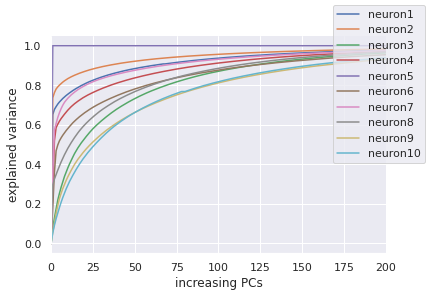

In [968]:
values = {}
num_neurons = 10

for j in range(0, num_neurons):
    value_list = []
    for i in range(0, n_images):
        value = np.sum(uks[j][:i])/np.sum(uks[j][:])   
        value_list.append(value)
    values[j] = value_list
 


with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots()
axs.plot(values[0], label = "neuron1")
axs.plot(values[1], label = "neuron2")
axs.plot(values[2], label = "neuron3")
axs.plot(values[3], label = "neuron4")
axs.plot(values[4], label = "neuron5")
axs.plot(values[5], label = "neuron6")
axs.plot(values[6], label = "neuron7")
axs.plot(values[7], label = "neuron8")
axs.plot(values[8], label = "neuron9")
axs.plot(values[9], label = "neuron10")

axs.set_xlim(0, 200)
axs.set_ylabel('explained variance')
axs.set_xlabel('increasing PCs')
sns.despine(trim=True)
fig.legend()

plt.savefig('explained_variance')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


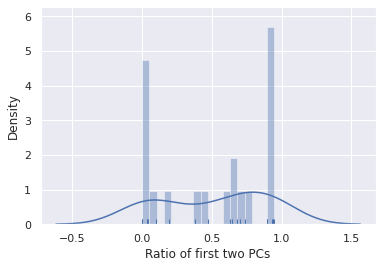

In [973]:
import seaborn as sns
import pandas as pd
sns.set()
x = pd.Series(eig_ratio, name="Ratio of first two PCs")
sns.distplot(x, np.linspace(0,1,20), rug=True)

plt.savefig("density_plot.png")

### Here the reconstructing part is coming

In [ ]:

RFs_new = RFs.cpu().detach().numpy()

Xpca_list = []
components_included = []
#n_components = 150

for i in range(0, 10):
    ###calculate n_components for neurons individually:
    n_comp = 0
    for value in values[i]:
        if value > 0.99:
            n_components = n_comp
            break
        n_comp += 1
    
    components_included.append(n_components)
    rfs_flattened = RFs_new[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    

    rfs_mean = rfs_flattened.mean(axis=1, keepdims=True)
    rfs_flattened = rfs_flattened - rfs_mean

    #we have to be careful if we are considering the kernel matrix or the covariance matrix
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, eig_vecs = eig(K)

    uk, eig_vecs = map(np.real, (uk, eig_vecs))
    
    ### ordering the eigenvalues and eigenvectors accendingly
    uk, eigvecs = uk[::-1], eig_vecs[:, ::-1]
    

    # get the n-most important eigenvectors:
    matrix_v = eig_vecs[:,0:n_components]

    
    ## P = V ` V ` t
    I = matrix_v.T @ matrix_v
    
    I2 = np.eye(I.shape[0])
    
    np.testing.assert_almost_equal(I, I2, decimal=6)
    
    P = matrix_v @ matrix_v.T 
    
    ## reconstructed x = P * x
    Xpca = P @ rfs_flattened 
    
    
    #normalize the images again:
    Xpca += rfs_mean
    
    
    #bringing images back in shape
    Xpca = np.reshape(Xpca,(n_images,img_x, img_y)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component
    
    Xpca_list.append(Xpca)


    #decode_matrices.append(v3.copy())

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(25,25))
j = 0 #neuron
i = 0

best = best_20[j]
images = dataloader["train"][best['data_key']].dataset[:].inputs
    

for k in range(0, 5):
    for p in np.arange(0, step=2, stop=6):
    #for p in range(0, 5):
        max_intensity=np.max(np.abs(Xpca_list[j][i,:,:]))
        axs[k][p].title.set_text(str('image: '+ str(i))+ ', PCs used: ' + str(components_included[j]))
        axs[k][p].imshow(Xpca_list[j][i,:,:] ,cmap=  'viridis', vmin=-max_intensity, vmax = max_intensity)
        axs[k][p].axis('off')
        
        axs[k][p+1].imshow(images[i,:,:].squeeze(0) ,cmap=  'gray')
        axs[k][p+1].axis('off')
        i+=1
        
plt.savefig('neuron1_90percent_var_explained')

#### Now visualizing the reconstructed gradient field images

##### starting with 2 components

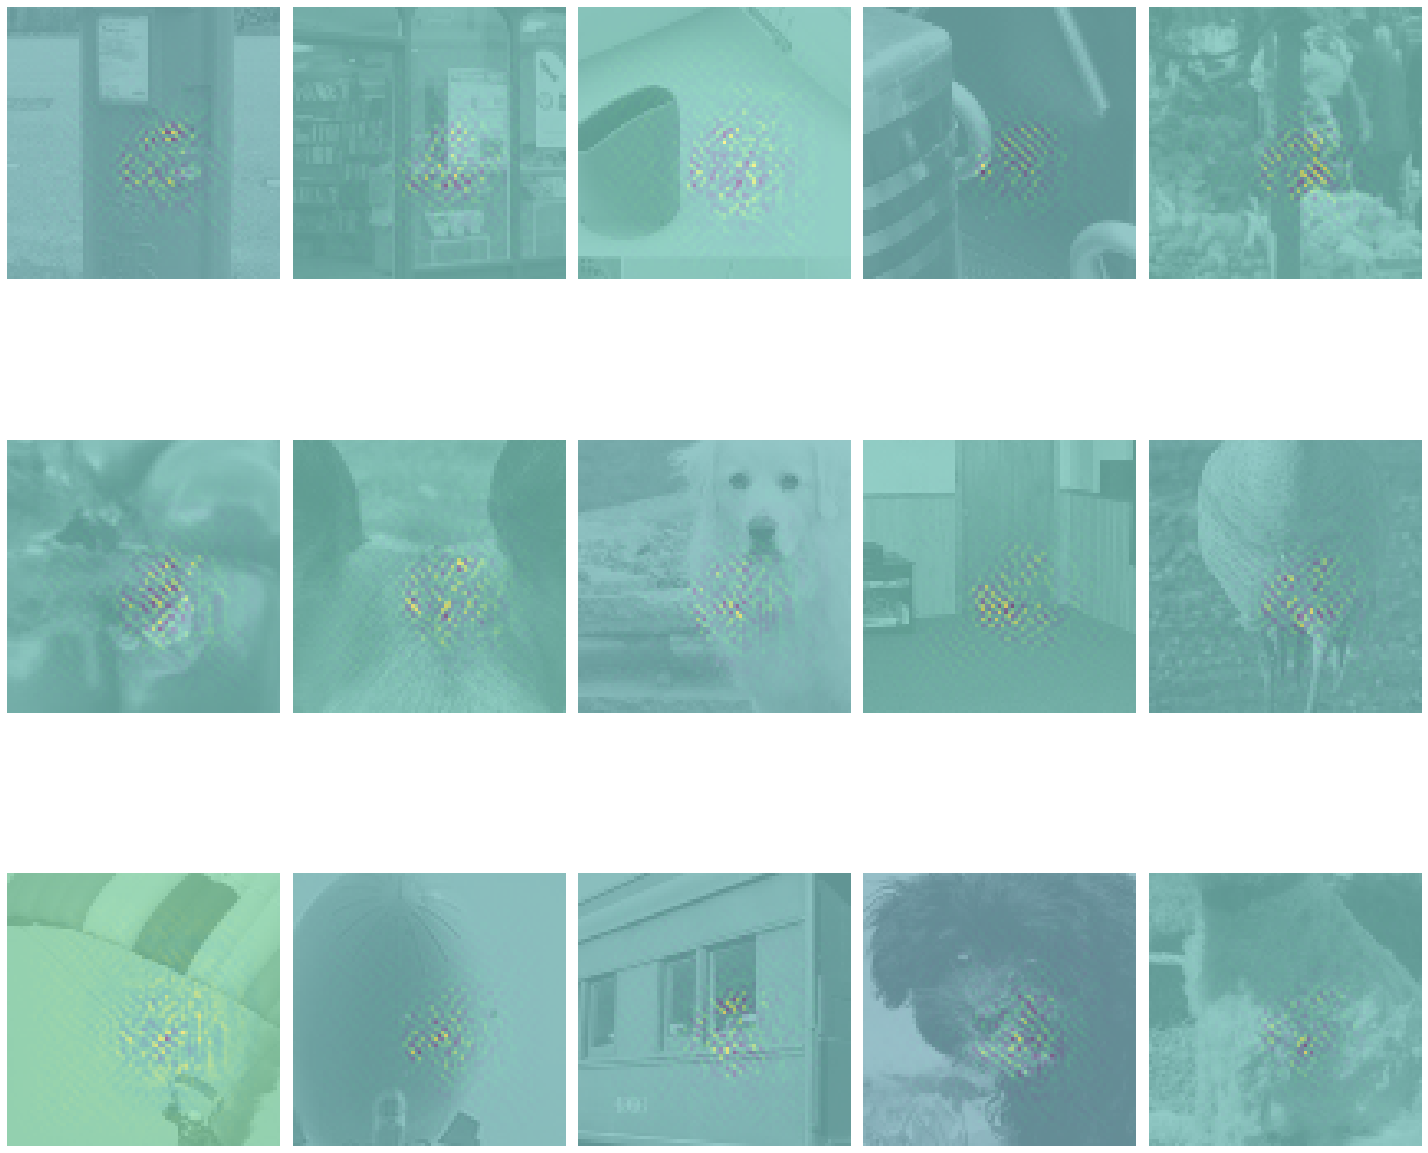

In [902]:
import matplotlib.colors as col

j = 0 #neuron
i = 0



best = best_five[j]
images = dataloader["train"][best['data_key']].dataset[:].inputs
    
fig, axs = plt.subplots(3, 5, figsize=(20,20))

for k in range(0, 3):
    for p in range(0, 5):
    #for p in np.arange(0, step=2, stop=10):
    
        axs[k][p].imshow(Xpca_list[j][i,:,:] ,cmap=  'viridis', alpha=0.6)
        
        axs[k][p].imshow(images[i,:,:].squeeze(0) ,cmap=  'gray', alpha=0.2)
        i+= 1
        axs[k][p].axis('off')
        #axs[k][p+1].axis('off')
    

plt.axis('off')
plt.savefig("kPCA_1neuron")
fig.tight_layout()



### Now the same for 5 components

In [598]:
RFs_new = RFs.cpu().detach().numpy()

Xpca_list_5 = []
n_components = 5

for i in range(0, 5):
    rfs_flattened = RFs_new[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    

    rfs_mean = rfs_flattened.mean(axis=1, keepdims=True)
    rfs_flattened = rfs_flattened - rfs_mean
    
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, eig_vecs = eig(K)

    uk, eig_vecs = map(np.real, (uk, eig_vecs))
    
    ### ordering the eigenvalues and eigenvectors accendingly
    uk, eigvecs = uk[::-1], eig_vecs[:, ::-1]

    
    # get the n-most important eigenvectors:
    matrix_v = eig_vecs[:,0:n_components]

    
    ## P = V ` V ` t
    I = matrix_v.T @matrix_v
    
    I2 = np.eye(I.shape[0])
    
    np.testing.assert_almost_equal(I, I2, decimal=6)
    
    P = matrix_v @ matrix_v.T 
    
    ## reconstructed x = P * x
    Xpca = P @ rfs_flattened 
    
    
    #normalize the images again:
    Xpca += rfs_mean
    
    
    #bringing images back in shape
    Xpca = np.reshape(Xpca,(n_images,img_x, img_y)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component
    
    Xpca_list_5.append(Xpca)



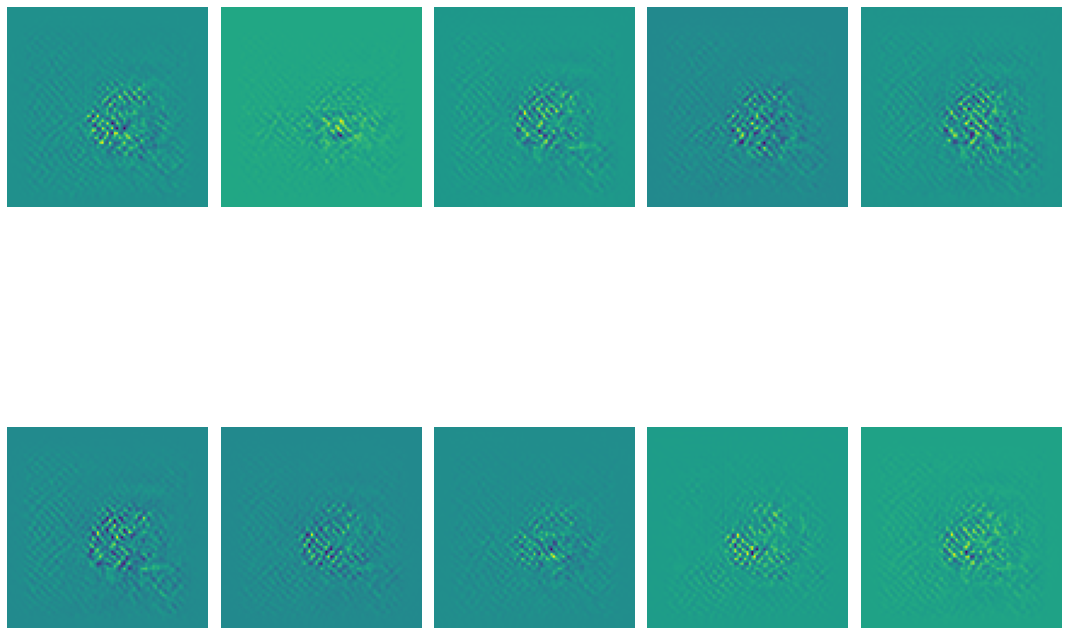

In [600]:
fig, axs = plt.subplots(2, 5, figsize=(15,15))
j = 0 #neuron
i = 0
for k in range(0, 2):
    for p in range(0, 5):
    
        axs[k][p].imshow(Xpca_list_5[j][i,:,:] ,cmap=  'viridis')
        i+= 1
        axs[k][p].axis('off')
    

plt.axis('off')
plt.savefig("kPCA_1neuron")
fig.tight_layout()


#### Now with 10 components

In [778]:
RFs_new = RFs.cpu().detach().numpy()

Xpca_list_150 = []
n_components = 150

for i in range(0, 5):
    rfs_flattened = RFs_new[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    

    rfs_mean = rfs_flattened.mean(axis=1, keepdims=True)
    rfs_flattened = rfs_flattened - rfs_mean
    
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, eig_vecs = eig(K)

    uk, eig_vecs = map(np.real, (uk, eig_vecs))
    
    ### ordering the eigenvalues and eigenvectors accendingly
    uk, eigvecs = uk[::-1], eig_vecs[:, ::-1]
    
    #x.T * U (U are eigenvectors)
    #v2 = rfs_flattened.T @ eig_vecs
    #v2 /= np.sqrt( (v2**2).sum(axis=0, keepdims=True)) # normalize each column to length 1 v/||v||_2
    #v3 = np.reshape(v2,(img_x, img_y, n_images)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component
    
    
    # get the n-most important eigenvectors:
    matrix_v = eig_vecs[:,0:n_components]

    
    ## P = V ` V ` t
    I = matrix_v.T @matrix_v
    
    I2 = np.eye(I.shape[0])
    
    np.testing.assert_almost_equal(I, I2, decimal=6)
    
    P = matrix_v @ matrix_v.T 
    
    ## reconstructed x = P * x
    Xpca = P @ rfs_flattened 
    
    
    #normalize the images again:
    Xpca += rfs_mean
    
    
    #bringing images back in shape
    Xpca = np.reshape(Xpca,(n_images,img_x, img_y)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component

    Xpca_list_150.append(Xpca)

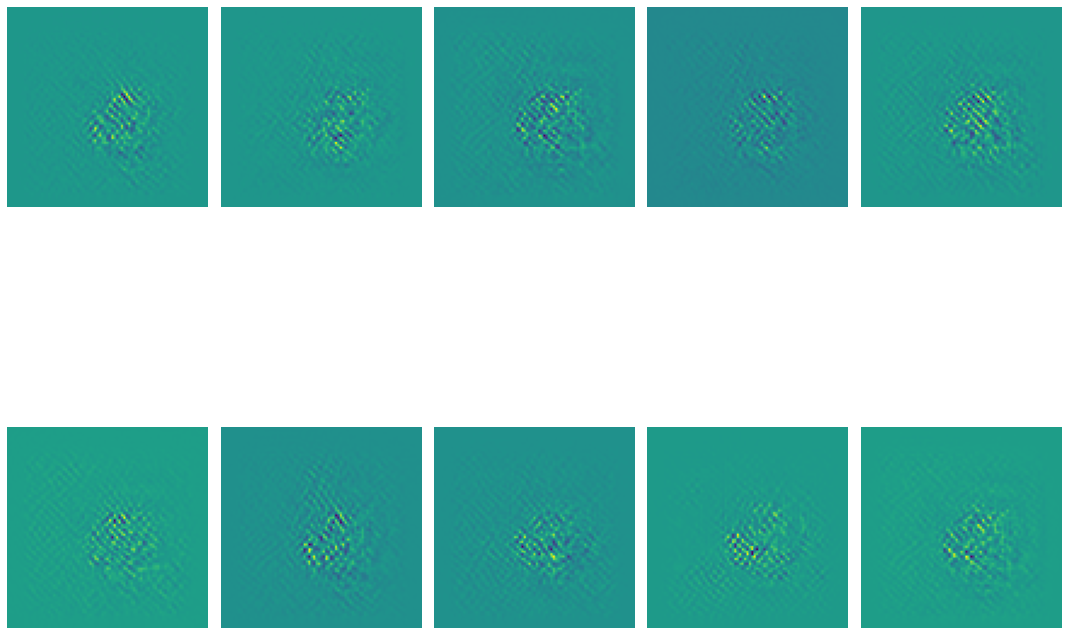

In [603]:
fig, axs = plt.subplots(2, 5, figsize=(15,15))
j = 0 #neuron
i = 0
for k in range(0, 2):
    for p in range(0, 5):
    
        img = axs[k][p].imshow(Xpca_list_10[j][i,:,:] ,cmap=  'viridis')
        i+= 1
        axs[k][p].axis('off')
    

plt.axis('off')
plt.savefig("kPCA_1neuron")
fig.tight_layout()
#fig.colorbar(img)



In [987]:
RFs_new = RFs.cpu().detach().numpy()

Xpca_list_250 = []
n_components = 250

for i in range(0, 5):
    rfs_flattened = RFs_new[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    

    rfs_mean = rfs_flattened.mean(axis=1, keepdims=True)
    rfs_flattened = rfs_flattened - rfs_mean
    
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, eig_vecs = eig(K)

    uk, eig_vecs = map(np.real, (uk, eig_vecs))
    
    ### ordering the eigenvalues and eigenvectors accendingly
    uk, eigvecs = uk[::-1], eig_vecs[:, ::-1]
    
    #x.T * U (U are eigenvectors)
    #v2 = rfs_flattened.T @ eig_vecs
    #v2 /= np.sqrt( (v2**2).sum(axis=0, keepdims=True)) # normalize each column to length 1 v/||v||_2
    #v3 = np.reshape(v2,(img_x, img_y, n_images)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component
    
    
    # get the n-most important eigenvectors:
    matrix_v = eig_vecs[:,0:n_components]

    
    ## P = V ` V ` t
    I = matrix_v.T @matrix_v
    
    I2 = np.eye(I.shape[0])
    
    np.testing.assert_almost_equal(I, I2, decimal=6)
    
    P = matrix_v @ matrix_v.T 
    
    ## reconstructed x = P * x
    Xpca = P @ rfs_flattened 
    
    
    #normalize the images again:
    Xpca += rfs_mean
    
    
    #bringing images back in shape
    Xpca = np.reshape(Xpca,(n_images,img_x, img_y)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component
    
    Xpca_list_250.append(Xpca)

In [606]:
#fig, axs = plt.subplots(2, 5, figsize=(15,15))
#j = 1 #neuron
#i = 0
#for k in range(0, 2):
#    for p in range(0, 5):
        
#        OldMax = np.max(Xpca_list_10[j][i,:,:])
#        OldMin = np.min(Xpca_list_10[j][i,:,:])
#        OldRange = np.abs(OldMax) + np.abs(OldMin)
#        print('min', OldMin)
#        print(OldRange)
        
#        NewRange = (255 - 0)  
        
 #       Xpca_list_10[j][i,:,:] = (((Xpca_list_10[j][i,:,:] - OldMin) * NewRange) / OldRange) 
#        
 #       img = axs[k][p].imshow(Xpca_list_10[j][i,:,:] ,cmap=  'viridis', vmin=0, vmax=255)
        
#        i+= 1
#        axs[k][p].axis('off')
    

#plt.axis('off')
#plt.savefig("kPCA_1neuron")
#fig.tight_layout()
#fig.colorbar(img)

#### Now I do a comparison between the reconstructions between 2, 5, 10, 150, 250 components

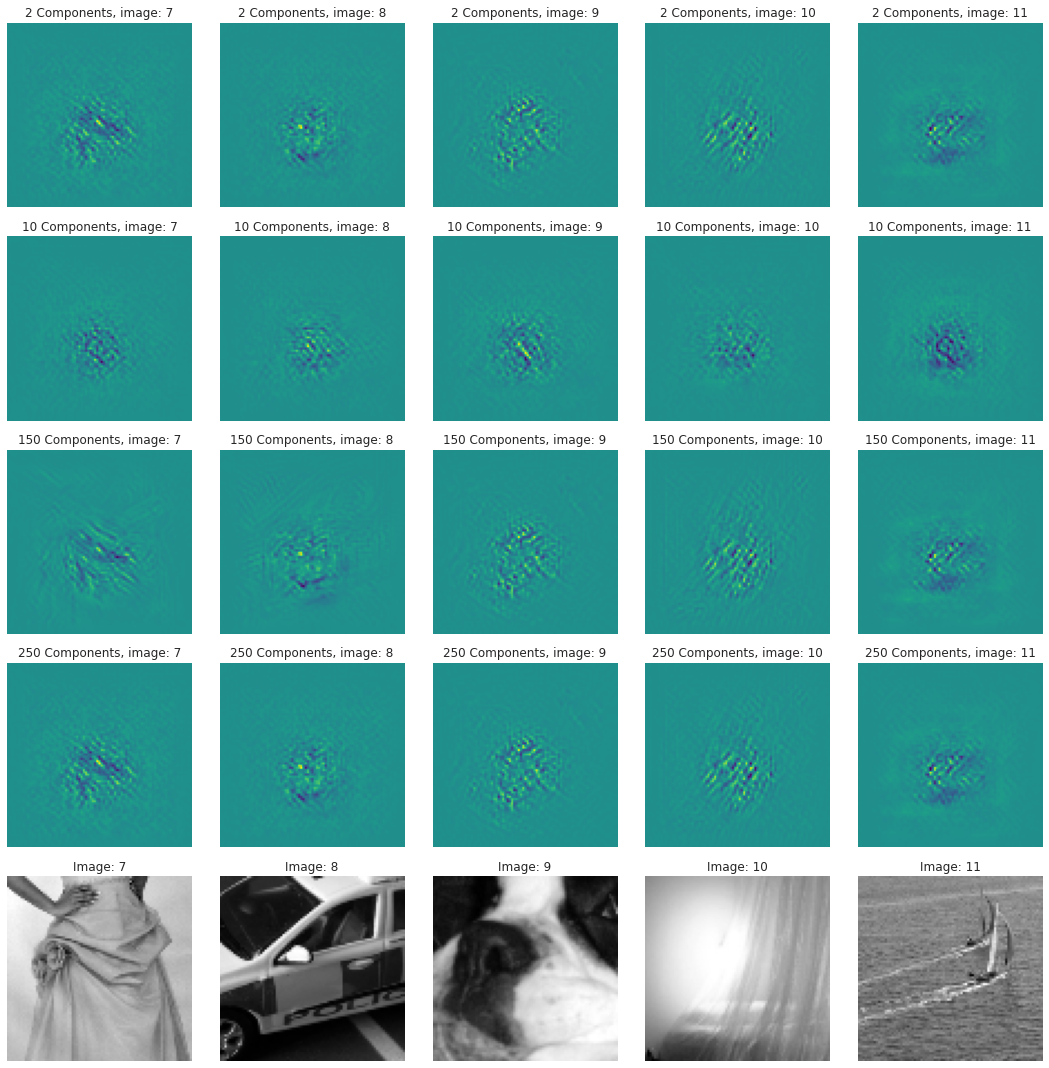

In [988]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
j = 2 #neuron
i = 7

best = best_five[j]
images = dataloader["train"][best['data_key']].dataset[:].inputs
    

for p in range(0, 5):
    max_intensity=np.max(np.abs(Xpca_list[j][i,:,:]))
    axs[0][p].title.set_text(str('2 Components, image: '+ str(i)))
    axs[0][p].imshow(Xpca_list[j][i,:,:] ,cmap=  'viridis', vmin=-max_intensity, vmax = max_intensity)
    axs[0][p].axis('off')
    
    max_10 = np.max(np.abs(Xpca_list_10[j][i,:,:]))
    axs[1][p].title.set_text(str('10 Components, image: '+ str(i)))
    axs[1][p].imshow(Xpca_list_10[j][i,:,:] ,cmap=  'viridis', vmin=-max_10, vmax=max_10)
    axs[1][p].axis('off')
    
    max_150 = np.max(np.abs(Xpca_list_150[j][i,:,:]))
    axs[2][p].title.set_text(str('150 Components, image: '+ str(i)))
    axs[2][p].imshow(Xpca_list_150[j][i,:,:] ,cmap=  'viridis', vmin=-max_150, vmax=max_150)
    axs[2][p].axis('off')   
    
    max_250 = np.max(np.abs(Xpca_list_250[j][i,:,:]))
    axs[3][p].title.set_text(str('250 Components, image: '+ str(i)))
    axs[3][p].imshow(Xpca_list_250[j][i,:,:] ,cmap=  'viridis', vmin=-max_250, vmax=max_250)
    axs[3][p].axis('off') 
    
    axs[4][p].title.set_text(str('Image: '+ str(i)))
    axs[4][p].imshow(images[i,:,:].squeeze(0) ,cmap=  'gray')
    axs[4][p].axis('off') 
    i+= 1

plt.axis('off')
plt.savefig("kPCA_bestneuron_different_components")
fig.tight_layout()

#### Looking at same more images for the reconstruction with 150 images

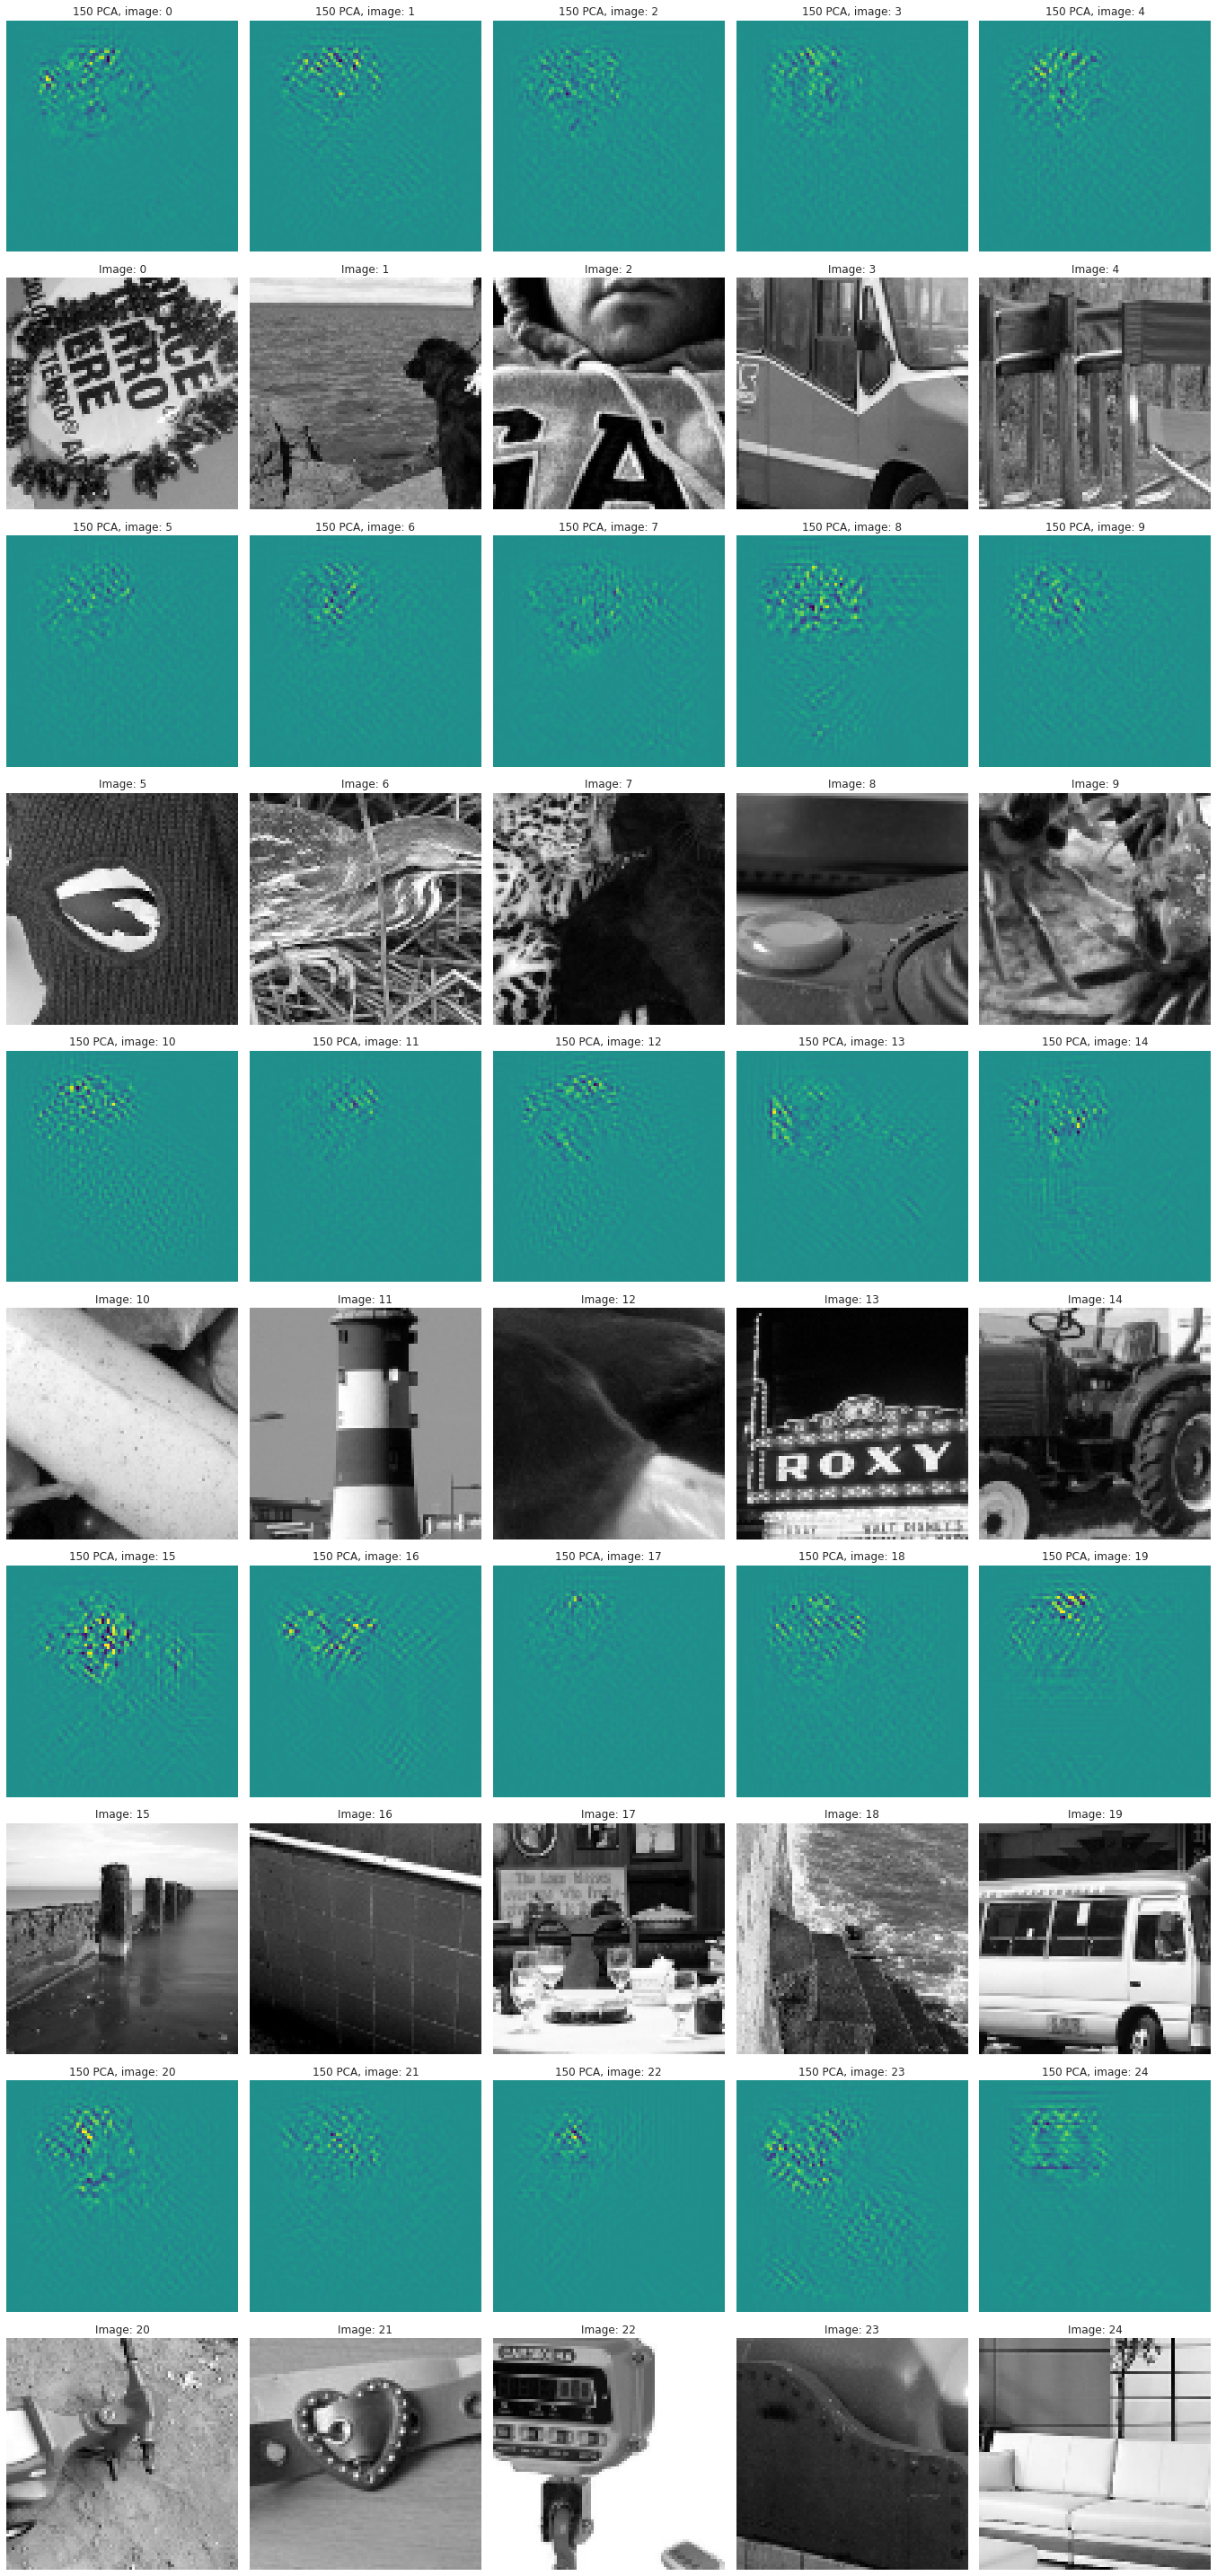

In [992]:
fig, axs = plt.subplots(10, 5, figsize=(20,40))
j = 4 #neuron
i = 0

best = best_five[j]
images = dataloader["train"][best['data_key']].dataset[:].inputs
    

for p in np.arange(0, step=2, stop=10):
    for k in range(0, 5):

        max_150 = np.max(np.abs(Xpca_list_150[j][i,:,:]))
        #concat = np.concatenate((Xpca_list_150[j][i,:,:], images[i,:,:].squeeze(0)), axis=1)
        axs[p][k].title.set_text(str('150 PCA, image: '+ str(i)))
        axs[p][k].imshow(Xpca_list[j][i,:,:] ,cmap=  'viridis', vmin=-max_150, vmax=max_150)
        axs[p][k].axis('off')   

    
        axs[p+1][k].title.set_text(str('Image: '+ str(i)))
        axs[p+1][k].imshow(images[i,:,:].squeeze(0) ,cmap=  'gray')
        axs[p+1][k].axis('off') 
        i+= 1
        
plt.subplots_adjust(
                    wspace=0.001, 
                    hspace=0.5)

plt.axis('off')
plt.savefig("kPCA_examples_neuron5")
plt.tight_layout()

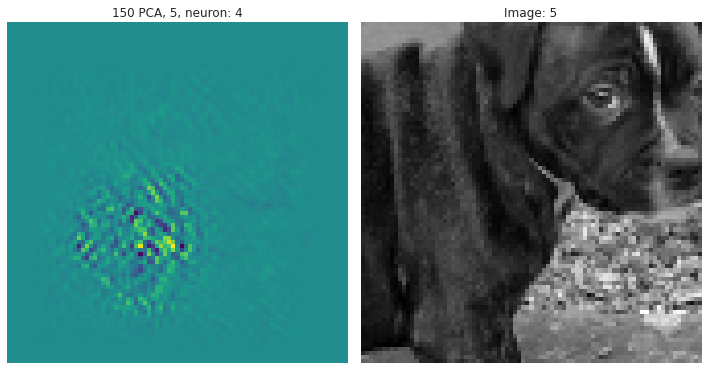

In [990]:
fig, axs = plt.subplots(1,2,figsize=(10,10))
j = 3 #neuron
i = 5

best = best_five[j]
images = dataloader["train"][best['data_key']].dataset[:].inputs
    

axs[0].title.set_text(str('150 PCA, '+ str(i) +', neuron: '+str(j+1)))
axs[0].imshow(Xpca_list[j][i,:,:] ,cmap=  'viridis')
axs[0].axis('off')   

    
axs[1].title.set_text(str('Image: '+ str(i)))
axs[1].imshow(images[i,:,:].squeeze(0) ,cmap=  'gray')
axs[1].axis('off') 
      

plt.axis('off')
plt.savefig("kPCA_example_dog")
fig.tight_layout()

In [ ]:
RFs_new = RFs.cpu().detach().numpy()

Xpca_list_150 = []
n_components = 150

for i in range(0, 5):
    rfs_flattened = RFs_new[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    

    rfs_mean = rfs_flattened.mean(axis=1, keepdims=True)
    rfs_flattened = rfs_flattened - rfs_mean
    
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, eig_vecs = eig(K)

    uk, eig_vecs = map(np.real, (uk, eig_vecs))
    
    ### ordering the eigenvalues and eigenvectors accendingly
    uk, eigvecs = uk[::-1], eig_vecs[:, ::-1]
    
    #x.T * U (U are eigenvectors)
    #v2 = rfs_flattened.T @ eig_vecs
    #v2 /= np.sqrt( (v2**2).sum(axis=0, keepdims=True)) # normalize each column to length 1 v/||v||_2
    #v3 = np.reshape(v2,(img_x, img_y, n_images)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component
    
    
    # get the n-most important eigenvectors:
    matrix_v = eig_vecs[:,0:n_components]

    
    ## P = V ` V ` t
    I = matrix_v.T @matrix_v
    
    I2 = np.eye(I.shape[0])
    
    np.testing.assert_almost_equal(I, I2, decimal=6)
    
    P = matrix_v @ matrix_v.T 
    
    ## reconstructed x = P * x
    Xpca = P @ rfs_flattened 
    
    
    #normalize the images again:
    Xpca += rfs_mean
    
    
    #bringing images back in shape
    Xpca = np.reshape(Xpca,(n_images,img_x, img_y)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component

    Xpca_list_150.append(Xpca)